In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import holoviews as hv
# hv.extension('bokeh')
import hvplot.xarray
import hvplot.pandas
from bokeh.models import DatetimeTickFormatter, FixedTicker, TickFormatter

import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import whenever 
import glob
import os
import pytz
from timezonefinder import TimezoneFinder


In [2]:
## Note: if cfeatures do not work, download manually to directory: 
# import cartopy 
# print(cartopy.config['data_dir'])

In [3]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [4]:
tf = TimezoneFinder() 

# Function to convert local standard time (no DLS) time to UTC
def local_std_to_utc_std(df,col,lat,lon):
    def convert_row(row):
        # Find the timezone for the given lat/lon
        timezone_str = tf.timezone_at(lat=lat, lng=lon)
        if timezone_str is not None:
            timezone = pytz.timezone(timezone_str)
            # Localize datetime without DST
            standard_time = timezone.normalize(timezone.localize(row[col], is_dst=False))
            # Convert to UTC
            return standard_time.astimezone(pytz.utc)
        else:
            raise ValueError('Cannot determine site time zone')
            
    df['utc_time'] = df.apply(convert_row,axis=1)
    return df

In [5]:
proj=ccrs.PlateCarree()

In [6]:
# Import site metadata csv
filepath = 'ameriflux-data/'
meta_file = filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only
# fluxnet_simple = fluxnet_meta[['Site ID', 'Longitude (degrees)', 'Latitude (degrees)', 'Years of AmeriFlux FLUXNET Data']] #drop unneeded columns

In [7]:
# Example sites of varying geography
site_list = ['US-A32', 'US-Bar', 'US-RGB', 'US-xJE', 'US-SRC']
sites_meta = ameriflux_meta.loc[ameriflux_meta['Site ID'].isin(site_list)]
sites_meta

,Site ID,Name,Principal Investigator,Data Use Policy,AmeriFlux BASE Data,AmeriFlux FLUXNET Data,Vegetation Abbreviation (IGBP),Vegetation Description (IGBP),Climate Class Abbreviation (Koeppen),Climate Class Description (Koeppen),...,Longitude (degrees),Elevation (m),Years of AmeriFlux BASE Data,AmeriFlux BASE DOI,Years of AmeriFlux FLUXNET Data,AmeriFlux FLUXNET DOI,Site Start,Site End,BASE variables available,FLUXNET variables available
133,US-A32,ARM-SGP Medford hay pasture,Sebastien Biraud (scbiraud@lbl.gov),CC-BY-4.0,Yes,Yes,GRA,Grasslands: Lands with herbaceous types of cov...,Cfa,"Humid Subtropical: mild with no dry season, ho...",...,-97.8198,335.0,"2015, 2016, 2017",https://doi.org/10.17190/AMF/1436327,"2015, 2016, 2017",https://doi.org/10.17190/AMF/1881568,2015.0,2017.0,"ALB, CO2, FC, G, H, H2O, LE, LW_IN, LW_OUT, ND...",NaN
157,US-Bar,Bartlett Experimental Forest,Andrew Richardson (Andrew.Richardson@nau.edu),CC-BY-4.0,Yes,Yes,DBF,Deciduous Broadleaf Forests: Lands dominated b...,Dfb,Warm Summer Continental: significant precipita...,...,-71.2881,272.0,"2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011...",https://doi.org/10.17190/AMF/1246030,"2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011...",https://doi.org/10.17190/AMF/2006969,2004.0,NaN,"CO2, FC, H, LE, NETRAD, P, PA, PPFD_BC_IN, PPF...",NaN
477,US-RGB,Butte County Rice Farm,Sebastien C. Biraud (SCBiraud@lbl.gov),CC-BY-4.0,Yes,Yes,CRO,Croplands: Lands covered with temporary crops ...,Csa,"Mediterranean: mild with dry, hot summer",...,-121.8579,33.0,"2021, 2022, 2023",https://doi.org/10.17190/AMF/1870591,2021,https://doi.org/10.17190/AMF/2204874,2021.0,NaN,"CO2, FC, FC_SSITC_TEST, FETCH_70, FETCH_80, FE...",NaN
530,US-SRC,Santa Rita Creosote,Shirley (Kurc) Papuga (shirley.papuga@gmail.com),CC-BY-4.0,Yes,Yes,OSH,Open Shrublands: Lands with woody vegetation l...,Bwh,Desert: warm winter,...,-110.8395,950.0,"2008, 2009, 2010, 2011, 2012, 2013, 2014",https://doi.org/10.17190/AMF/1246127,"2008, 2009, 2010, 2011, 2012, 2013, 2014",https://doi.org/10.17190/AMF/1871145,2008.0,2018.0,"CO2, FC, G, H, H2O, LE, LW_IN, LW_OUT, NETRAD,...",NaN
640,US-xJE,NEON Jones Ecological Research Center (JERC),National Ecological Observatory Network (neon-...,CC-BY-4.0,Yes,Yes,ENF,Evergreen Needleleaf Forests: Lands dominated ...,Cfa,"Humid Subtropical: mild with no dry season, ho...",...,-84.4686,44.0,"2017, 2018, 2019, 2020, 2021, 2022, 2023",https://doi.org/10.17190/AMF/1617730,"2017, 2018, 2019, 2020, 2021",https://doi.org/10.17190/AMF/1985443,2017.0,NaN,"CH4, CH4_MIXING_RATIO, CO2, CO2C13, CO2_MIXING...",NaN


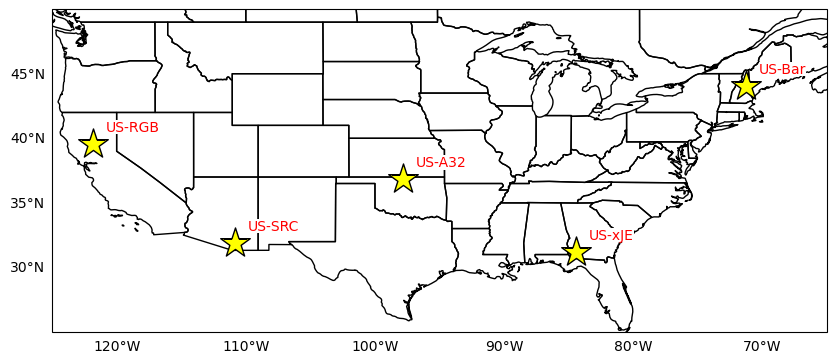

In [8]:
# Plot sites
# subset CONUS
min_lon, max_lon = -125, -65
min_lat, max_lat = 25, 50

fig, ax = plt.subplots(figsize=(10,6),subplot_kw= {'projection': proj});
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=proj);
ax.add_feature(cfeature.STATES)

for site_ID in site_list:
    site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

    ax.scatter(site_lon,site_lat,
           marker='*', 
           s=500,
           color='yellow',
           edgecolor='black', zorder=3)
    ax.annotate(site_ID, (site_lon + 1,site_lat+1),
                color='red',
                bbox=dict(facecolor='white',edgecolor='None', pad=0.1,
                         )
                         
               )
    

# ax.legend(loc='lower left')
gl = ax.gridlines(draw_labels=True,x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False

In [9]:
# Create a function to plot
def get_loc_data(site_ID):
    
    ## Fluxnet Data 
    # Import selected site half-hourly data (HH) Subset data
    
    site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

    filepath = 'ameriflux-data/'
    sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_HH_*.csv')
    fluxnet_sel = pd.read_csv(sel_file)

    # select subset of columns + convert to datetime objects
    fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP_START','TIMESTAMP_END', 'NEE_VUT_REF']].copy()
    fluxnet_sel_simple['TIMESTAMP_START'] = pd.to_datetime(fluxnet_sel_simple ['TIMESTAMP_START'],format='%Y%m%d%H%M')
    fluxnet_sel_simple['TIMESTAMP_END'] = pd.to_datetime(fluxnet_sel_simple ['TIMESTAMP_END'],format='%Y%m%d%H%M')

    # Convert time zone (Fluxnet reported in local standard time)
    fluxnet_sel_simple = local_std_to_utc_std(fluxnet_sel_simple,'TIMESTAMP_START',site_lat, site_lon)
    fluxnet_sel_simple = fluxnet_sel_simple.set_index('utc_time')

    # Convert units
    # FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
    fluxnet_sel_final = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3
    fluxnet_sel_final.name = 'FluxNET NEE (kgC m-2 s-1)'

    # resample to 3-hourly per MiCASA
    fluxnet_sel_final = fluxnet_sel_final.resample('3h').mean()
    
    # Import MiCASA from data-extract.py
    dir = 'output'
    filename = f'{site_ID}_micasa.csv'
    path = os.path.join(dir, filename)
    micasa_ds = pd.read_csv(path,index_col=0)

    # Create datetime index and specify UTC
    micasa_ds.index = pd.to_datetime(micasa_ds.index)
    micasa_ds.index = micasa_ds.index.tz_localize('UTC')
    micasa_ds.index.name = 'utc_time'

    # Append together
    plot_ds = micasa_ds.merge(fluxnet_sel_final,left_index=True, right_index=True)
    return plot_ds

In [10]:
# Define misc plotting variables
site_subset = ['Site ID', 
                'Name', 
                'Vegetation Description (IGBP)', 
                'Climate Class Description (Koeppen)', 
                'Elevation (m)',
                'Years of AmeriFlux FLUXNET Data']

datetimeformatter = DatetimeTickFormatter(
    hours='%H:%M',
    days='%m/%d %H:%M',
    months='%b %Y',
)
    # months='%b %Y %H:%M'),

# US-A32

In [12]:
site_ID =  'US-A32'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
133,US-A32,ARM-SGP Medford hay pasture,"Grasslands: Lands with herbaceous types of cover. Tree and shrub cover is less than 10%. Permanent wetlands lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water.","Humid Subtropical: mild with no dry season, hot summer",335.0,"2015, 2016, 2017"


In [13]:
A32_data = get_loc_data(site_ID)

In [14]:
A32_data.hvplot(
    kind='line',
    width=1300, height=400,
    # groupby=['utc_time.year'],
    groupby=['utc_time.year', 'utc_time.month'],
    widget_location='bottom',
    # xaxis={'ticker':FixedTicker(ticks=[i*6*3600*1000 for i in range(24)])},
    xformatter= datetimeformatter,
    yformatter='%.1e',
    ylabel = 'NEE (kg C m-2 s-1)',
    title = f'{site_ID}',
    legend='bottom',
    grid=True,
)    

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', width=1300)
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='utc_time.year', options={'2015': np.int32(2015), ...}, value=np.int32(2015))
        [1] DiscreteSlider(name='utc_time.month', options={'1': np.int32(1), ...}, value=np.int32(1))

# US-RGB

In [15]:
site_ID =  'US-RGB'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
477,US-RGB,Butte County Rice Farm,"Croplands: Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.","Mediterranean: mild with dry, hot summer",33.0,2021


In [16]:
RGB_data = get_loc_data(site_ID)

In [17]:
RGB_data.hvplot(
    kind='line',
    width=1300, height=400,
    # groupby=['utc_time.year'],
    groupby=['utc_time.year', 'utc_time.month'],
    widget_location='bottom',
    # xaxis={'ticker':FixedTicker(ticks=[i*6*3600*1000 for i in range(24)])},
    xformatter= datetimeformatter,
    yformatter='%.1e',
    ylabel = 'NEE (kg C m-2 s-1)',
    title = f'{site_ID}',
    legend='bottom',
    grid=True,
)    

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', width=1300)
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='utc_time.year', options={'2021': np.int32(2021), ...}, value=np.int32(2021))
        [1] DiscreteSlider(name='utc_time.month', options={'1': np.int32(1), ...}, value=np.int32(1))

# US-Bar

In [11]:
site_ID =  'US-Bar'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
157,US-Bar,Bartlett Experimental Forest,Deciduous Broadleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods.,Warm Summer Continental: significant precipitation in all seasons,272.0,"2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021"


In [12]:
Bar_data = get_loc_data(site_ID)

In [13]:
Bar_data.hvplot(
    kind='line',
    width=1300, height=400,
    # groupby=['utc_time.year'],
    groupby=['utc_time.year', 'utc_time.month'],
    widget_location='bottom',
    # xaxis={'ticker':FixedTicker(ticks=[i*6*3600*1000 for i in range(24)])},
    xformatter= datetimeformatter,
    yformatter='%.1e',
    ylabel = 'NEE (kg C m-2 s-1)',
    title = f'{site_ID}',
    legend='bottom',
    grid=True,
)    

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', width=1300)
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='utc_time.year', options={'2004': np.int32(2004), ...}, value=np.int32(2004))
        [1] DiscreteSlider(name='utc_time.month', options={'1': np.int32(1), ...}, value=np.int32(1))

# US-xJE

In [20]:
site_ID =  'US-xJE'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
640,US-xJE,NEON Jones Ecological Research Center (JERC),Evergreen Needleleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees remain green all year. Canopy is never without green foliage.,"Humid Subtropical: mild with no dry season, hot summer",44.0,"2017, 2018, 2019, 2020, 2021"


In [21]:
xJE_data = get_loc_data(site_ID)

In [22]:
xJE_data.hvplot(
    kind='line',
    width=1300, height=400,
    # groupby=['utc_time.year'],
    groupby=['utc_time.year', 'utc_time.month'],
    widget_location='bottom',
    # xaxis={'ticker':FixedTicker(ticks=[i*6*3600*1000 for i in range(24)])},
    xformatter= datetimeformatter,
    yformatter='%.1e',
    ylabel = 'NEE (kg C m-2 s-1)',
    title = f'{site_ID}',
    legend='bottom',
    grid=True,
)    

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', width=1300)
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='utc_time.year', options={'2017': np.int32(2017), ...}, value=np.int32(2017))
        [1] DiscreteSlider(name='utc_time.month', options={'1': np.int32(1), ...}, value=np.int32(1))

# US-SRC

In [23]:
site_ID =  'US-SRC'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
530,US-SRC,Santa Rita Creosote,Open Shrublands: Lands with woody vegetation less than 2 meters tall and with shrub canopy cover between 10-60%. The shrub foliage can be either evergreen or deciduous.,Desert: warm winter,950.0,"2008, 2009, 2010, 2011, 2012, 2013, 2014"


In [24]:
SRC_data = get_loc_data(site_ID)

In [25]:
SRC_data.hvplot(
    kind='line',
    width=1300, height=400,
    # groupby=['utc_time.year'],
    groupby=['utc_time.year', 'utc_time.month'],
    widget_location='bottom',
    # xaxis={'ticker':FixedTicker(ticks=[i*6*3600*1000 for i in range(24)])},
    xformatter= datetimeformatter,
    yformatter='%.1e',
    ylabel = 'NEE (kg C m-2 s-1)',
    title = f'{site_ID}',
    legend='bottom',
    grid=True,
)   

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', width=1300)
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='utc_time.year', options={'2008': np.int32(2008), ...}, value=np.int32(2008))
        [1] DiscreteSlider(name='utc_time.month', options={'1': np.int32(1), ...}, value=np.int32(1))